<a href="https://colab.research.google.com/github/PatTheAtak/ADALINE-with-Stochastic-Gradient-Descent-Minibatch-/blob/master/ADALINE_with_SGD(Minibatch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

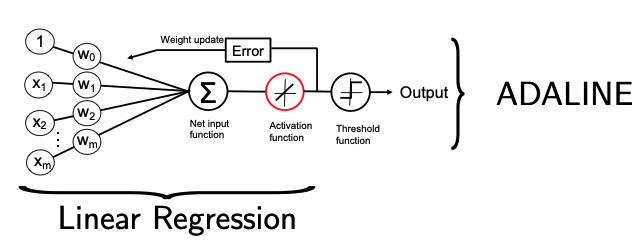

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Loading the dataset

In [4]:
df = pd.read_csv('iris.data.txt', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.head()

,x1,x2,x3,x4,y
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


In [6]:
# Create Features and Targets
#

X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Split into train, test splits & Shuffle
#

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0) * 0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)
# 

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

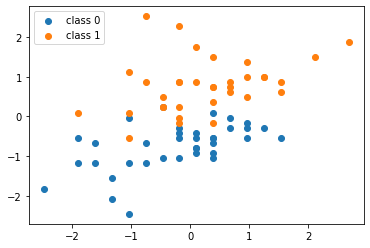

In [7]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 1')
plt.legend()
plt.show()

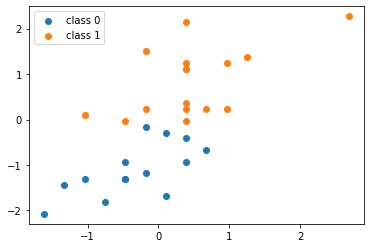

In [8]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.legend()
plt.show()

## ADALINE Model

In [17]:
class Adaline():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(yhat - y)
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights = torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

## Train & Eval Functions

In [18]:
# Calculate the loss
def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

In [19]:
# Train the model
#

model = Adaline(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.1,
             seed=123,
             minibatch_size=10)

    Minibatch MSE: 0.500
    Minibatch MSE: 0.341
    Minibatch MSE: 0.220
    Minibatch MSE: 0.245
    Minibatch MSE: 0.157
    Minibatch MSE: 0.133
    Minibatch MSE: 0.144
Epoch: 001 | MSE: 0.12142
    Minibatch MSE: 0.107
    Minibatch MSE: 0.147
    Minibatch MSE: 0.064
    Minibatch MSE: 0.079
    Minibatch MSE: 0.185
    Minibatch MSE: 0.063
    Minibatch MSE: 0.135
Epoch: 002 | MSE: 0.09932
    Minibatch MSE: 0.093
    Minibatch MSE: 0.064
    Minibatch MSE: 0.128
    Minibatch MSE: 0.099
    Minibatch MSE: 0.079
    Minibatch MSE: 0.157
    Minibatch MSE: 0.080
Epoch: 003 | MSE: 0.09693
    Minibatch MSE: 0.131
    Minibatch MSE: 0.146
    Minibatch MSE: 0.050
    Minibatch MSE: 0.095
    Minibatch MSE: 0.106
    Minibatch MSE: 0.072
    Minibatch MSE: 0.102
Epoch: 004 | MSE: 0.09658
    Minibatch MSE: 0.107
    Minibatch MSE: 0.204
    Minibatch MSE: 0.149
    Minibatch MSE: 0.054
    Minibatch MSE: 0.060
    Minibatch MSE: 0.056
    Minibatch MSE: 0.069
Epoch: 005 | MSE: 0.0

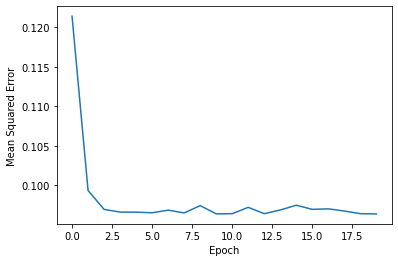

In [20]:
# Plot loss MSE
#

plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [21]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-0.0763],
        [ 0.4181]])
Bias tensor([0.4888])
